### Couple Things to note:

* keras.utils.plot_model doesn't work (says need to install graphviz but that didn't work?).
* GPU is not being utilised; not sure why, something to do with [CUDA](https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64) and other things

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten , Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer
!python --version
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Python 3.12.3
TensorFlow version: 2.16.1
Num GPUs Available:  0


### Extract dataset and visualise

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
# normalise the data to 0-1
train_images = train_images / 255.0 # training data
test_images = test_images / 255.0 # testing data
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


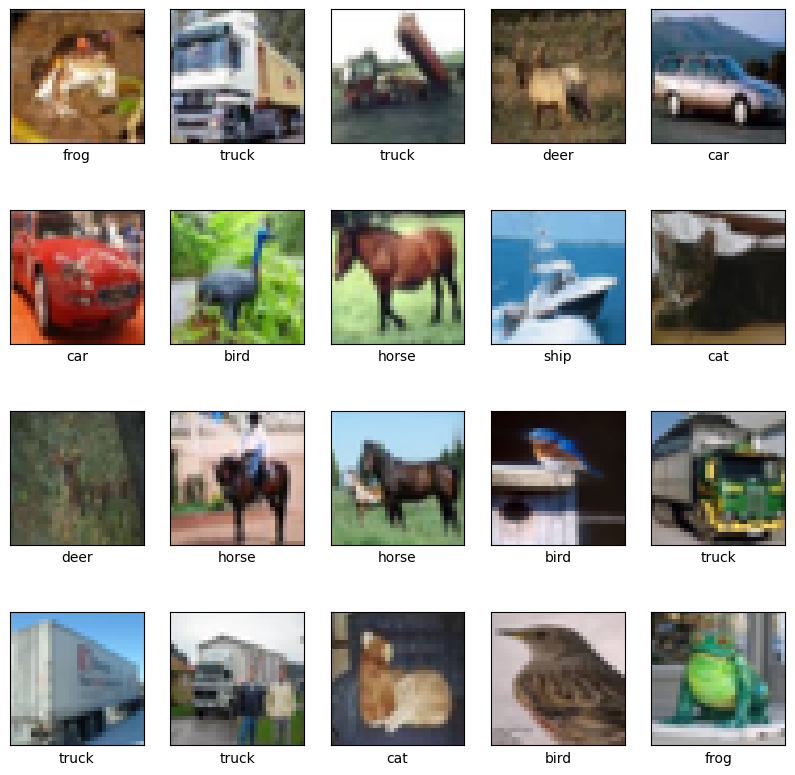

In [3]:
class_names = ['airplane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [1]:
# Before one hot encoding
# print("train_images Shape: %s and value: %s" % (train_images.shape, train_images))
# print("test_images Shape: %s and value: %s" % (test_images.shape, test_images))
train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

# After one hot encoding
print("train_images Shape: %s and value: %s" % (train_labels.shape, train_labels[0]))
print("test_images Shape: %s and value: %s" % (test_labels.shape, test_labels[1]))

NameError: name 'to_categorical' is not defined

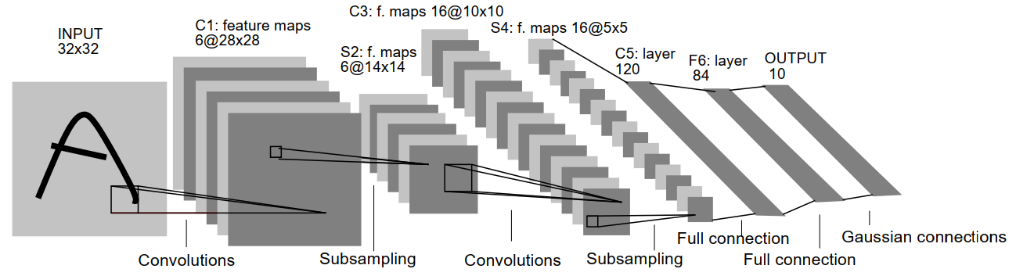

### Create the model

In [5]:
model = models.Sequential([
  layers.Input(shape=(32, 32, 3)),
  
  #==================== Feature Detection / extraction Block ====================#

# Add first convolutional block - To deal with images we use Conv2D and for colour images and shape use Conv3D

  # First convolutional block
  (layers.Conv2D(64, (3, 3), activation='relu')), 
  (layers.Conv2D(64, (3,3),activation='relu')),
  (layers.MaxPooling2D((2, 2))),
  (Dropout(0.25)),
  # Second convolutional block
  (layers.Conv2D(128, (3, 3), activation='relu')), 
  (layers.Conv2D(128, (3,3),activation='relu')),
  (layers.MaxPooling2D((2, 2))),
  (Dropout(0.25)),
  # Third convolutional block
  (layers.Conv2D(256, (3, 3), activation='relu')),
  (layers.MaxPooling2D((2, 2))),
  (Dropout(0.25)),
  
#==================== Transition Block (from feature detection to classification) ====================#

  (layers.Flatten()),
  
#==================== Classification Block ====================#
# Classification segment - fully connected network
# The Dence layer does classification and is deep neural network. Dense layer always accept the array.
  
  (layers.Dense(128, activation='relu')),
  (layers.Dense(100, activation='relu')),
  (layers.Dense(80, activation='relu')),

  # Add the output layer
  (layers.Dense(10, activation='softmax'))
])
dot_img_file = '/tmp/model_1.png'
# plot_model(model, to_file=dot_img_file, show_shapes=True) # doesn't work cause graphviz?

### Compile it with the Adam optimizer and the binary crossentropy loss function and train it

**CARE!** Even 10 epochs takes ~10 mins (on CPU). You can increase the number of epochs to get better results.

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
optimizer = Adam(learning_rate=0.001) # default is 0.001, try 0.0001 or 0.00001 if necessary


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training_images=train_images.reshape(50000,32,32,3)
testing_images=test_images.reshape(10000,32,32,3)
# model.summary()
history = model.fit(training_images, train_labels, epochs=10, batch_size=32, validation_split=(0.2), callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
1202/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2339 - loss: 2.0028

KeyboardInterrupt: 

### Graph accuracy and loss, and evaluate

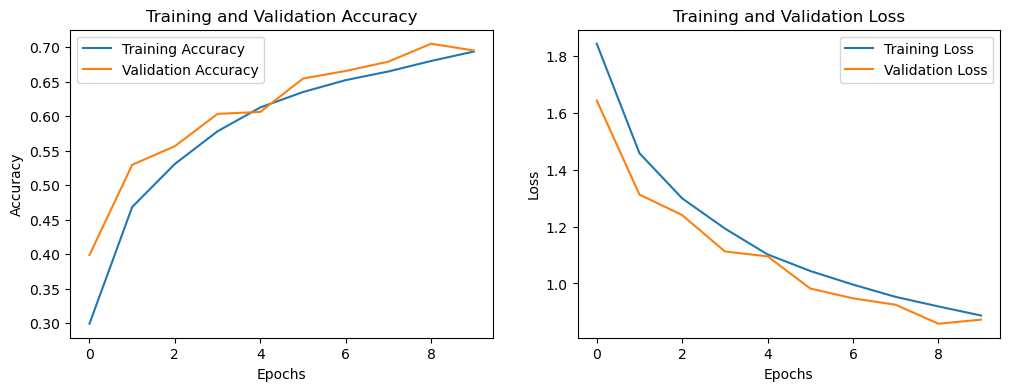

In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc*100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6791 - loss: 0.8927
Test Accuracy: 68.70%


### Now use the model to make predictions on the test set!

In [ ]:
predictions = model.predict(testing_images)
# predicted_labels = np.argmax(predictions, axis=1)
print(predictions[0])


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
[0.0079096  0.0059168  0.03753826 0.6385341  0.01481118 0.10310871
 0.132865   0.00991024 0.03179815 0.01760788]


In [ ]:
def plot_image(i, predictions_array, true_label, img): # taking index and 3 arrays viz. prediction array, true label array and image array
  
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary) # showing b/w image

  predicted_label=np.argmax(predictions_array)
  true_label=np.argmax(true_label)

  # print(predicted_label)
  # print(true_label)
  
  if predicted_label == true_label: #setting up label color
    color='blue' # correct then blue colour
    
  else:
    color='red' # wrong then red colour

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                       100*np.max(predictions_array),
                                       class_names[true_label]),
             color=color)
  
# function to display bar chart showing whether image prediction is how much correct  
def plot_value_array(i, predictions_array, true_label): # taking index along with predictions and true label array
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot=plt.bar(range(10), predictions_array, color='gray')
  plt.ylim([0,1])
  predicted_label=np.argmax(predictions_array)
  true_label=np.argmax(true_label)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

In [ ]:
# verification of several images

num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i,predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()